In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch
from keras import layers
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import metrics
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from sklearn.metrics import f1_score
from keras.models import load_model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.metrics import AUC


import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

Image Preprocessing

In [2]:
# Set the path to your datasets
BASE_PATH_TRAIN = "C:\\kaggle\\input\\ArTaxOr"
BASE_PATH_TEST = "C:\\DL Testing Set"

# Step 1: Image Preprocessing
image_train = []
labels_train = []

for root, dirs, files in os.walk(BASE_PATH_TRAIN):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image_train.append(os.path.join(root, file))
                labels_train.append(label)

data_train = {'Images': image_train, 'labels': labels_train}
data_train = pd.DataFrame(data_train)

lb = LabelEncoder()
data_train['encoded_labels'] = lb.fit_transform(data_train['labels'])

image_test = []
labels_test = []

for root, dirs, files in os.walk(BASE_PATH_TEST):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image_test.append(os.path.join(root, file))
                labels_test.append(label)

data_test = {'Images': image_test, 'labels': labels_test}
data_test = pd.DataFrame(data_test)

data_test['encoded_labels'] = lb.transform(data_test['labels'])

# Number of classes (insects)
num_classes = len(lb.classes_)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



In [3]:
# Create data generator
batch_size = 64

# Training Data Generator
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    dataframe=data_train,
    x_col="Images",
    y_col="labels",
    subset="training",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224, 224)
)

# Validation Data Generator
val_generator = datagen.flow_from_dataframe(
    dataframe=data_train,
    x_col="Images",
    y_col="labels",
    subset="validation",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224, 224)
)


# Assuming you have train_gen and test_gen already defined as ImageDataGenerator instances
train_gen = ImageDataGenerator(rescale=(1./255.), validation_split=0.2)
test_gen = ImageDataGenerator(rescale=(1./255.))

Found 12301 validated image filenames belonging to 7 classes.
Found 3075 validated image filenames belonging to 7 classes.


Training the Insect Classification Model

In [4]:
# Step 2: Model Modification for Insect Classification

def get_alexnet_model(num_classes):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model



In [5]:
# Create the model
alexnet_model = get_alexnet_model(num_classes)

In [11]:
# Compile the model

from keras.models import load_model


alexnet_model.compile(loss="categorical_crossentropy",
                      optimizer=SGD(learning_rate=0.001, momentum=0.9),
                      metrics=['accuracy', metrics.Recall(), metrics.Precision(), metrics.AUC()])


train_dir = BASE_PATH_TRAIN


# Train AlexNet
history_alexnet = alexnet_model.fit(
    train_gen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=batch_size, 
                                  class_mode='categorical', subset='training'),
    epochs=10,
    validation_data=train_gen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=batch_size, 
                                                  class_mode='categorical', subset='validation'),
    callbacks=[EarlyStopping(patience=3)]
)


# Save the model
alexnet_model.save("C:/Deep Learning/Project/Classification Models/alexnet_modelv2.h5")

# Save training history to a CSV file
history_df = pd.DataFrame(history_alexnet.history)
history_df.to_csv("C:/Deep Learning/Project/Classification Models/alexnet_historyv2.csv", index=False)


Found 12303 images belonging to 7 classes.
Found 3073 images belonging to 7 classes.
Epoch 1/10
193/193 [==============================] - 3269s 17s/step - loss: 1.2902 - accuracy: 0.5396 - recall_2: 0.3952 - precision_2: 0.7246 - auc_2: 0.8548 - val_loss: 0.9876 - val_accuracy: 0.6446 - val_recall_2: 0.5057 - val_precision_2: 0.7904 - val_auc_2: 0.9183
Epoch 2/10
193/193 [==============================] - 2024s 10s/step - loss: 1.0331 - accuracy: 0.6326 - recall_2: 0.5025 - precision_2: 0.7762 - auc_2: 0.9089 - val_loss: 0.9549 - val_accuracy: 0.6560 - val_recall_2: 0.5249 - val_precision_2: 0.7903 - val_auc_2: 0.9234
Epoch 3/10
193/193 [==============================] - 1932s 10s/step - loss: 0.9760 - accuracy: 0.6546 - recall_2: 0.5202 - precision_2: 0.7899 - auc_2: 0.9192 - val_loss: 0.9326 - val_accuracy: 0.6664 - val_recall_2: 0.5311 - val_precision_2: 0.7996 - val_auc_2: 0.9268
Epoch 4/10
193/193 [==============================] - 1955s 10s/step - loss: 0.9417 - accuracy: 0.6621

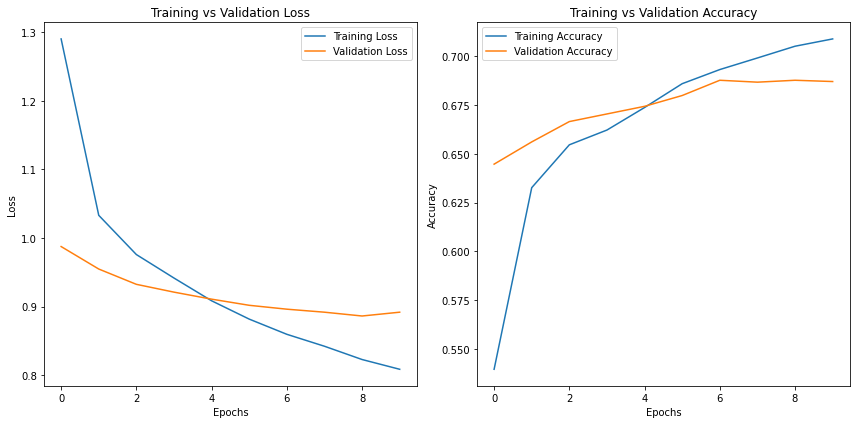

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
file_path = "C:/Deep Learning/Project/Classification Models/alexnet_historyv2.csv"  # Update with the correct file path
history_data = pd.read_csv(file_path)

# Plot Training vs Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_data['loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot Training vs Validation Accuracy
plt.subplot(1, 2, 2)
#plt.title("Accuracy and Loss with Custom InceptionV3 Model Trained on ArTaxOr")
plt.plot(history_data['accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# Predicting labels of Unlabeled Images

1/1 [==============================] - 0s 85ms/step


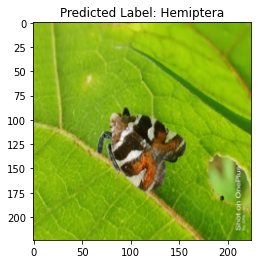

Predicted Label for the New Image: Hemiptera


In [7]:
# Specify the path to the new, unlabeled image
new_image_path = "C:/Unlabeled Images/IMG_20211017_080648.jpg"

# Load and preprocess the new image
new_image = Image.open(new_image_path)
new_image = new_image.resize((224, 224))
new_image_array = np.array(new_image) / 255.0  # Normalize pixel values
new_image_array = np.expand_dims(new_image_array, axis=0)  # Add batch dimension

# Make predictions on the new image
new_image_prediction = loaded_model.predict(new_image_array)

# Convert the prediction to a class label
predicted_label = lb.inverse_transform(new_image_prediction.argmax(axis=1))[0]

# Display the new image along with the predicted label
plt.imshow(new_image)
plt.title(f"Predicted Label: {predicted_label}")
plt.show()

print("Predicted Label for the New Image:", predicted_label)

1/1 [==============================] - 5s 5s/step


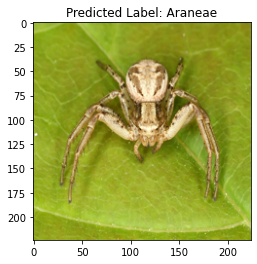

Predicted Label for the New Image: Araneae


In [20]:
# Specify the path to the new, unlabeled image
new_image_path = "C:/kaggle/input/ArTaxOr/Araneae/fa6b4011c1f0.jpg"

# Load and preprocess the new image
new_image = Image.open(new_image_path)
new_image = new_image.resize((224, 224))
new_image_array = np.array(new_image) / 255.0  # Normalize pixel values
new_image_array = np.expand_dims(new_image_array, axis=0)  # Add batch dimension

# Make predictions on the new image
new_image_prediction = loaded_model.predict(new_image_array)

# Convert the prediction to a class label
predicted_label = lb.inverse_transform(new_image_prediction.argmax(axis=1))[0]

# Display the new image along with the predicted label
plt.imshow(new_image)
plt.title(f"Predicted Label: {predicted_label}")
plt.show()

print("Predicted Label for the New Image:", predicted_label)


# Test Set = Mobile Corpus

In [14]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/alexnet_modelv2.h5")

# Test accuracy
test_generator = datagen.flow_from_dataframe(
    dataframe=data_test,
    x_col="Images",
    y_col="labels",
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode="categorical",
    target_size=(224, 224)
)

# Evaluate the model on the test set
test_results = loaded_model.evaluate(test_generator)

# Display the evaluation results
print("AlexNetv2 Test Loss:", test_results[0])
print("AlexNetv2 Test Accuracy:", test_results[1])

Found 14370 validated image filenames belonging to 7 classes.
225/225 [==============================] - 3684s 16s/step - loss: 0.9184 - accuracy: 0.6998 - recall_2: 0.5891 - precision_2: 0.8329 - auc_2: 0.9264
AlexNetv2 Test Loss: 0.9184090495109558
AlexNetv2 Test Accuracy: 0.6997912526130676


            labels  encoded_labels
0          Araneae               0
4776    Coleoptera               1
5315       Diptera               2
5892     Hemiptera               3
6580   Hymenoptera               4
7251   Lepidoptera               5
10649      Odonata               6
Found 14530 images belonging to 7 classes.
228/228 [==============================] - 2373s 10s/step - loss: 0.9174 - accuracy: 0.7003 - recall_2: 0.5900 - precision_2: 0.8333 - auc_2: 0.9266
Found 14530 images belonging to 7 classes.
228/228 [==============================] - 3527s 15s/step
AlexNetv2 Test Loss: 0.9174106121063232
AlexNetv2 Test Accuracy: 0.7003441452980042
1/1 [==============================] - 0s 100ms/step


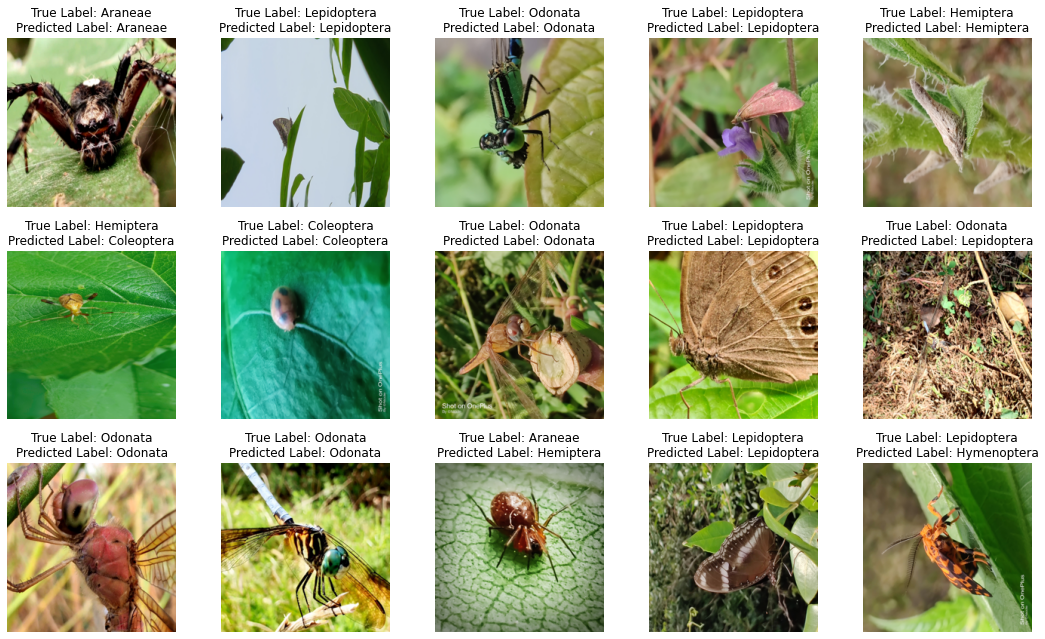

In [6]:
from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import load_model

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/alexnet_modelv2.h5")

# Set the path to the test set
test_dir = "C:\\DL Testing Set"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Testing Set"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]



# Retrieve true labels from the data dataframe
true_labels = []

# Create a list of indices and shuffle it
indices = list(range(len(data)))
np.random.shuffle(indices)

for i in range(15):  # Select 15 random images
    random_index = indices[i]
    img_name = data.iloc[random_index]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    true_labels.append(true_label)

# Convert the true labels to numpy array
true_labels = np.array(true_labels)

# Evaluate the model on the test set and make predictions
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))
predictions = loaded_model.predict(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Display the evaluation results
print("AlexNetv2 Test Loss:", test_results[0])
print("AlexNetv2 Test Accuracy:", test_results[1])

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Create a 3x5 subplot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
fig.tight_layout()

# Loop over the selected random images
for i in range(len(true_labels)):
    img_name = data.iloc[indices[i]]['Images']
    img_path = os.path.join(BASE_PATH, data.iloc[indices[i]]['labels'], img_name)
    true_label = lb.inverse_transform([true_labels[i]])[0]

    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)

    # Convert the prediction to a class label
    predicted_label = lb.inverse_transform(img_prediction.argmax(axis=1))[0]

    # Plot the image along with true and predicted labels
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")

# Show the plot
plt.show()


# Test Set = ArTaxOR

In [30]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

data_test2 = data_train

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/alexnet_modelv2.h5")

# Test accuracy
test_generator = datagen.flow_from_dataframe(
    dataframe=data_test2,
    x_col="Images",
    y_col="labels",
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode="categorical",
    target_size=(224, 224)
)

# Evaluate the model on the test set
test_results = loaded_model.evaluate(test_generator)

# Display the evaluation results
print("AlexNetv2 Test Loss:", test_results[0])
print("AlexNetv2 Test Accuracy:", test_results[1])

Found 15376 validated image filenames belonging to 7 classes.
241/241 [==============================] - 1256s 5s/step - loss: 0.7620 - accuracy: 0.7318 - recall_2: 0.6101 - precision_2: 0.8441 - auc_2: 0.9521
AlexNetv2 Test Loss: 0.7620394825935364
AlexNetv2 Test Accuracy: 0.7317898273468018


# Testing Prediction on ArTaxOR

            labels  encoded_labels
0          Araneae               0
2418    Coleoptera               1
4528       Diptera               2
6558     Hemiptera               3
8945   Hymenoptera               4
10993  Lepidoptera               5
13099      Odonata               6
Found 15376 images belonging to 7 classes.
241/241 [==============================] - 2703s 11s/step - loss: 0.7620 - accuracy: 0.7318 - recall_2: 0.6101 - precision_2: 0.8441 - auc_2: 0.9521
Found 15376 images belonging to 7 classes.
241/241 [==============================] - 2737s 11s/step
AlexNetv2 Test Loss: 0.7620395421981812
AlexNetv2 Test Accuracy: 0.7317898273468018
1/1 [==============================] - 0s 110ms/step


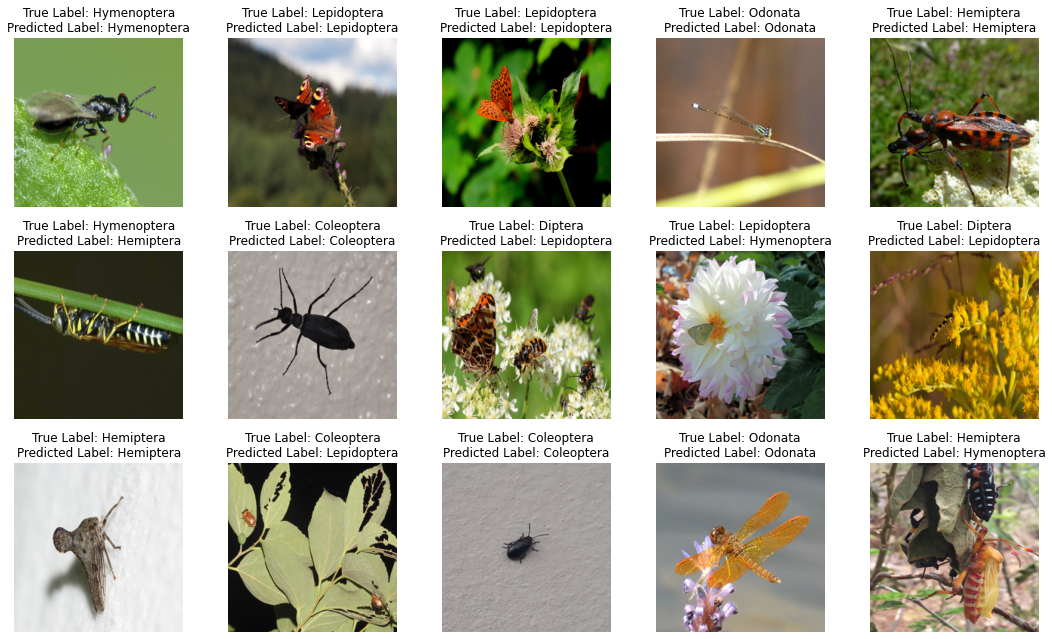

In [8]:


from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import load_model

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/alexnet_modelv2.h5")

# Set the path to the test set
test_dir = "C:\\kaggle\\input\\ArTaxOr"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\kaggle\\input\\ArTaxOr"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]



# Retrieve true labels from the data dataframe
true_labels = []

# Create a list of indices and shuffle it
indices = list(range(len(data)))
np.random.shuffle(indices)

for i in range(15):  # Select 15 random images
    random_index = indices[i]
    img_name = data.iloc[random_index]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    true_labels.append(true_label)

# Convert the true labels to numpy array
true_labels = np.array(true_labels)

# Evaluate the model on the test set and make predictions
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))
predictions = loaded_model.predict(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Display the evaluation results
print("AlexNetv2 Test Loss:", test_results[0])
print("AlexNetv2 Test Accuracy:", test_results[1])


# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Create a 3x5 subplot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
fig.tight_layout()

# Loop over the selected random images
for i in range(len(true_labels)):
    img_name = data.iloc[indices[i]]['Images']
    img_path = os.path.join(BASE_PATH, data.iloc[indices[i]]['labels'], img_name)
    true_label = lb.inverse_transform([true_labels[i]])[0]

    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)

    # Convert the prediction to a class label
    predicted_label = lb.inverse_transform(img_prediction.argmax(axis=1))[0]

    # Plot the image along with true and predicted labels
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")

# Show the plot
plt.show()



# Testing Prediction on DL Small Set Corpus

          labels  encoded_labels
0        Araneae               0
15    Coleoptera               1
35       Diptera               2
50     Hemiptera               3
69   Hymenoptera               4
88   Lepidoptera               5
103      Odonata               6
Found 118 images belonging to 7 classes.
2/2 [==============================] - 77s 34s/step - loss: 0.8500 - accuracy: 0.6864 - recall_2: 0.5424 - precision_2: 0.8101 - auc_2: 0.9388
Found 118 images belonging to 7 classes.
2/2 [==============================] - 84s 35s/step
AlexNetv2 Test Loss: 0.8500205278396606
AlexNetv2 Test Accuracy: 0.6864407062530518
1/1 [==============================] - 0s 285ms/step


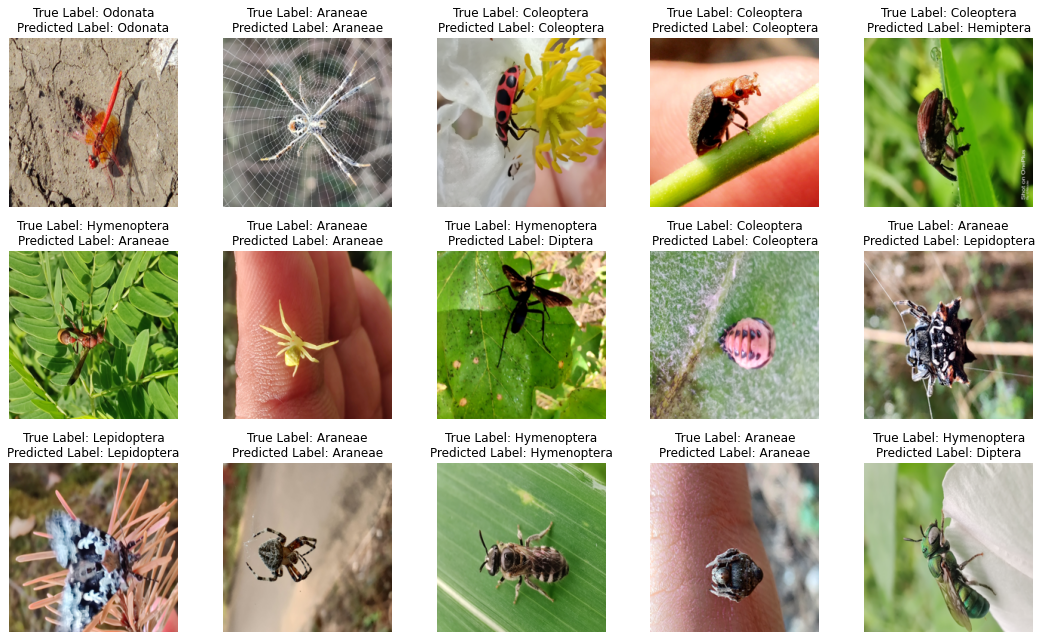

In [9]:
from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/alexnet_modelv2.h5")

# Set the path to the test set
test_dir = "C:\\DL Small Set"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Small Set"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]



# Retrieve true labels from the data dataframe
true_labels = []

# Create a list of indices and shuffle it
indices = list(range(len(data)))
np.random.shuffle(indices)

for i in range(15):  # Select 15 random images
    random_index = indices[i]
    img_name = data.iloc[random_index]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    true_labels.append(true_label)

# Convert the true labels to numpy array
true_labels = np.array(true_labels)

# Evaluate the model on the test set and make predictions
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))
predictions = loaded_model.predict(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Display the evaluation results
print("AlexNetv2 Test Loss:", test_results[0])
print("AlexNetv2 Test Accuracy:", test_results[1])


# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Create a 3x5 subplot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
fig.tight_layout()

# Loop over the selected random images
for i in range(len(true_labels)):
    img_name = data.iloc[indices[i]]['Images']
    img_path = os.path.join(BASE_PATH, data.iloc[indices[i]]['labels'], img_name)
    true_label = lb.inverse_transform([true_labels[i]])[0]

    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)

    # Convert the prediction to a class label
    predicted_label = lb.inverse_transform(img_prediction.argmax(axis=1))[0]

    # Plot the image along with true and predicted labels
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")

# Show the plot
plt.show()



# Testing Prediction on Mobile ArtaxOr Mix

          labels  encoded_labels
0        Araneae               0
31    Coleoptera               1
66       Diptera               2
96     Hemiptera               3
130  Hymenoptera               4
164  Lepidoptera               5
196      Odonata               6
Found 229 images belonging to 7 classes.
4/4 [==============================] - 98s 22s/step - loss: 0.7604 - accuracy: 0.7249 - recall_2: 0.6070 - precision_2: 0.8176 - auc_2: 0.9509
Found 229 images belonging to 7 classes.
4/4 [==============================] - 96s 21s/step
AlexNetv2 Test Loss: 0.760429859161377
AlexNetv2 Test Accuracy: 0.7248908281326294
1/1 [==============================] - 1s 622ms/step


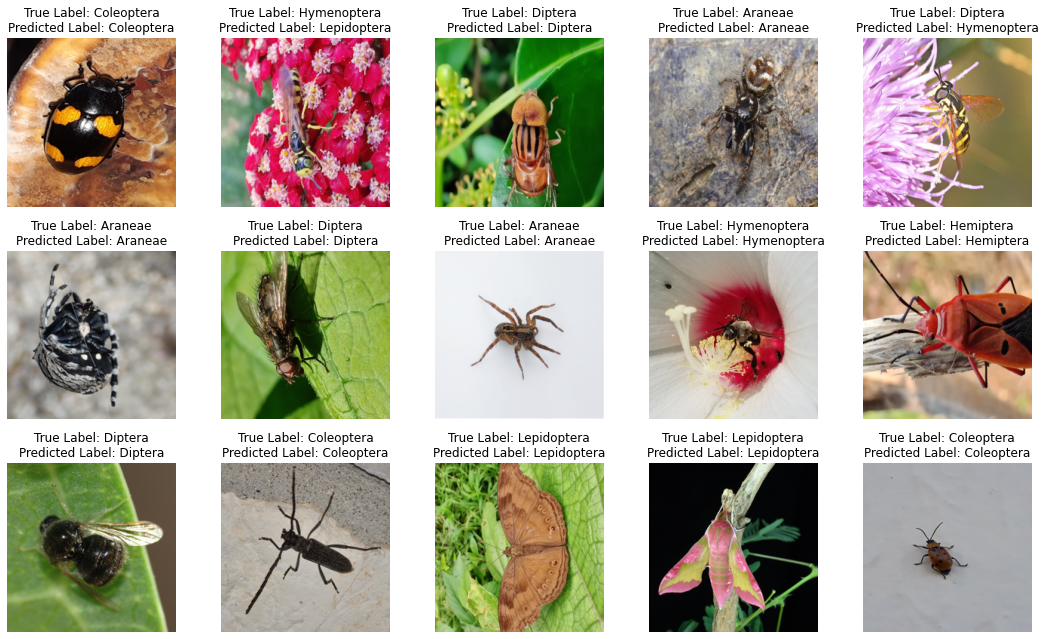

In [10]:
from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/alexnet_modelv2.h5")

# Set the path to the test set
test_dir = "C:\\DL Small Artax_Mobl Mix"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Small Artax_Mobl Mix"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]



# Retrieve true labels from the data dataframe
true_labels = []

# Create a list of indices and shuffle it
indices = list(range(len(data)))
np.random.shuffle(indices)

for i in range(15):  # Select 15 random images
    random_index = indices[i]
    img_name = data.iloc[random_index]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    true_labels.append(true_label)

# Convert the true labels to numpy array
true_labels = np.array(true_labels)

# Evaluate the model on the test set and make predictions
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))
predictions = loaded_model.predict(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Display the evaluation results
print("AlexNetv2 Test Loss:", test_results[0])
print("AlexNetv2 Test Accuracy:", test_results[1])


# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Create a 3x5 subplot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
fig.tight_layout()

# Loop over the selected random images
for i in range(len(true_labels)):
    img_name = data.iloc[indices[i]]['Images']
    img_path = os.path.join(BASE_PATH, data.iloc[indices[i]]['labels'], img_name)
    true_label = lb.inverse_transform([true_labels[i]])[0]

    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)

    # Convert the prediction to a class label
    predicted_label = lb.inverse_transform(img_prediction.argmax(axis=1))[0]

    # Plot the image along with true and predicted labels
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")

# Show the plot
plt.show()



In [29]:
loaded_model.summary()

#alexnet_modelv2

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

# Confusion Matrices

## ArTaxOr Mobile Corpus Mix

          labels  encoded_labels
0        Araneae               0
31    Coleoptera               1
66       Diptera               2
96     Hemiptera               3
130  Hymenoptera               4
164  Lepidoptera               5
196      Odonata               6
1/1 [==============================] - 0s 149ms/step


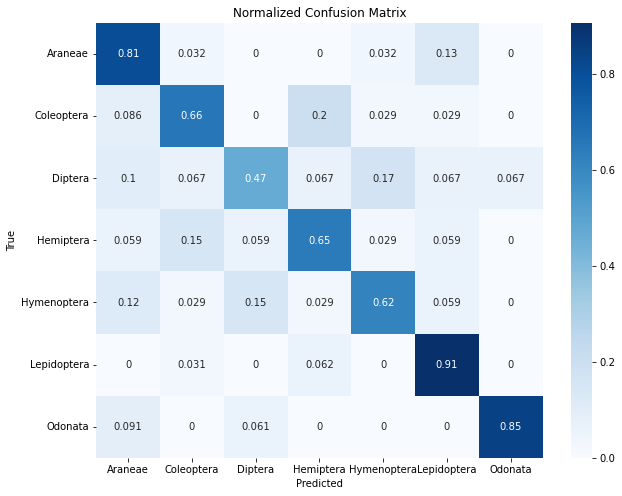

Classification Report:
              precision    recall  f1-score   support

     Araneae       0.62      0.81      0.70        31
  Coleoptera       0.70      0.66      0.68        35
     Diptera       0.61      0.47      0.53        30
   Hemiptera       0.65      0.65      0.65        34
 Hymenoptera       0.72      0.62      0.67        34
 Lepidoptera       0.72      0.91      0.81        32
     Odonata       0.93      0.85      0.89        33

    accuracy                           0.71       229
   macro avg       0.71      0.71      0.70       229
weighted avg       0.71      0.71      0.70       229



In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/alexnet_modelv2.h5")

# Set the path to the test set
test_dir = "C:\\DL Small Artax_Mobl Mix"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Small Artax_Mobl Mix"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels and predictions for the entire test set
true_labels = []
predicted_labels = []

# Loop over the entire test set
for i in range(len(data)):
    img_name = data.iloc[i]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    
    # Load and preprocess the image
    img_path = os.path.join(BASE_PATH, data.iloc[i]['labels'], img_name)
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)
    predicted_label = np.argmax(img_prediction)

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create a confusion matrix for the entire test set
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap of the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=unique_labels['labels'], yticklabels=unique_labels['labels'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the classification report for the entire test set
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_labels['labels']))

## Mobile Corpus

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/alexnet_modelv2.h5")

# Set the path to the test set
test_dir = "C:\\DL Testing Set"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Testing Set"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels and predictions for the entire test set
true_labels = []
predicted_labels = []

# Loop over the entire test set
for i in range(len(data)):
    img_name = data.iloc[i]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    
    # Load and preprocess the image
    img_path = os.path.join(BASE_PATH, data.iloc[i]['labels'], img_name)
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)
    predicted_label = np.argmax(img_prediction)

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create a confusion matrix for the entire test set
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap of the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=unique_labels['labels'], yticklabels=unique_labels['labels'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the classification report for the entire test set
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_labels['labels']))

            labels  encoded_labels
0          Araneae               0
4776    Coleoptera               1
5315       Diptera               2
5892     Hemiptera               3
6580   Hymenoptera               4
7251   Lepidoptera               5
10649      Odonata               6
1/1 [==============================] - 9s 9s/step


# ArTaxOr

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/alexnet_modelv2.h5")

# Set the path to the test set
test_dir = "C:\\kaggle\input\ArTaxOr"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\kaggle\input\ArTaxOr"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 128

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels and predictions for the entire test set
true_labels = []
predicted_labels = []

# Loop over the entire test set
for i in range(len(data)):
    img_name = data.iloc[i]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    
    # Load and preprocess the image
    img_path = os.path.join(BASE_PATH, data.iloc[i]['labels'], img_name)
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)
    predicted_label = np.argmax(img_prediction)

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create a confusion matrix for the entire test set
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap of the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=unique_labels['labels'], yticklabels=unique_labels['labels'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the classification report for the entire test set
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_labels['labels']))

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from keras.applications.inception_v3 import InceptionV3

def get_alexnet_model(num_classes):
    model = Sequential([
        # Base InceptionV3 model
        InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
        
        # Global average pooling layer
        layers.GlobalAveragePooling2D(),
        
        # Dense layer with 1024 units and ReLU activation
        layers.Dense(1024, activation='relu'),
        
        # Dropout layer with a rate of 0.5
        layers.Dropout(0.5),
        
        # Output layer with softmax activation
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

num_classes = 7  # Replace with the actual number of classes
inception_model = get_alexnet_model(num_classes)
inception_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 7)                 7175      
                                                                 
Total params: 23,908,135
Trainable params: 23,873,703
Non-trainable params: 34,432
_______________________________________

## No significant difference with this modification. Hence not considered for final analysis.

# Change Learning Rate to 0.0001, increase epochs

In [31]:
# Compile the model

from keras.models import load_model


alexnet_model.compile(loss="categorical_crossentropy",
                      optimizer=SGD(learning_rate=0.0001, momentum=0.9),
                      metrics=['accuracy', metrics.Recall(), metrics.Precision(), metrics.AUC()])


# Assuming you have train_dir and val_dir already defined
train_dir = BASE_PATH_TRAIN


# Train AlexNet
history_alexnet = alexnet_model.fit(
    train_gen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=batch_size, 
                                  class_mode='categorical', subset='training'),
    epochs=15,
    validation_data=train_gen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=batch_size, 
                                                  class_mode='categorical', subset='validation'),
    callbacks=[EarlyStopping(patience=3)]
)


# Save the model
alexnet_model.save("C:/Deep Learning/Project/Classification Models/artxalexnet_modelv4.h5")

# Save training history to a CSV file
history_df = pd.DataFrame(history_alexnet.history)
history_df.to_csv("C:/Deep Learning/Project/Classification Models/artxalexnet_historyv4.csv", index=False)

Found 12303 images belonging to 7 classes.
Found 3073 images belonging to 7 classes.
Epoch 1/15
193/193 [==============================] - 1799s 9s/step - loss: 0.7835 - accuracy: 0.7196 - recall_3: 0.6020 - precision_3: 0.8390 - auc_3: 0.9491 - val_loss: 0.8861 - val_accuracy: 0.6896 - val_recall_3: 0.5776 - val_precision_3: 0.8017 - val_auc_3: 0.9333
Epoch 2/15
193/193 [==============================] - 2860s 15s/step - loss: 0.7808 - accuracy: 0.7224 - recall_3: 0.6030 - precision_3: 0.8375 - auc_3: 0.9494 - val_loss: 0.8842 - val_accuracy: 0.6886 - val_recall_3: 0.5779 - val_precision_3: 0.8033 - val_auc_3: 0.9335
Epoch 3/15
193/193 [==============================] - 3290s 17s/step - loss: 0.7744 - accuracy: 0.7223 - recall_3: 0.6080 - precision_3: 0.8373 - auc_3: 0.9503 - val_loss: 0.8833 - val_accuracy: 0.6902 - val_recall_3: 0.5766 - val_precision_3: 0.8018 - val_auc_3: 0.9337
Epoch 4/15
193/193 [==============================] - 1696s 9s/step - loss: 0.7676 - accuracy: 0.7270 -

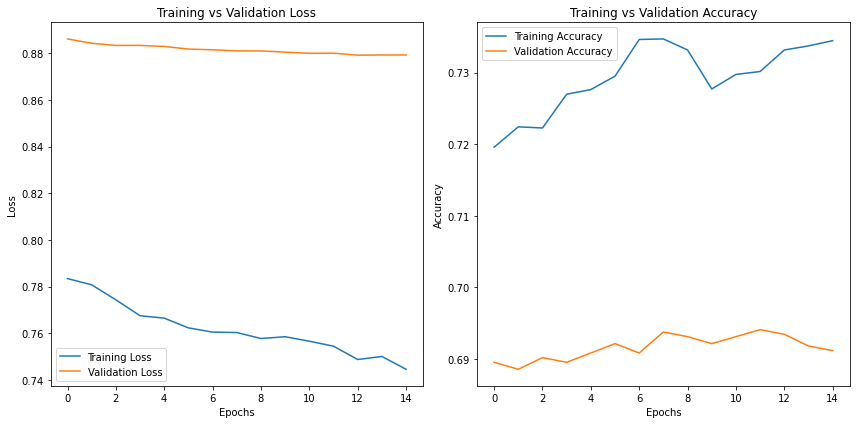

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
file_path = "C:/Deep Learning/Project/Classification Models/artxalexnet_historyv4.csv"  # Update with the correct file path
history_data = pd.read_csv(file_path)

# Plot Training vs Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_data['loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot Training vs Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_data['accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()